In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from tqdm import tqdm

In [133]:
def special_fill_nan(df:pd.DataFrame):
    columns = [column for column in df.columns if (column !='id' and column != 'Personality')]

    for col in columns:
        if df[col].dropna().isin(["Yes", "No"]).all(): # Converts "Yes" and "No" columns to numerical booleans
            df[col] = df[col].map({"Yes": 1, "No": 0})
            
    
    df_dict = df.to_dict(orient="records")

    for i in tqdm(range(len(df_dict))):
        nan_columns = [k for k, v in df_dict[i].items() if pd.isna(v)]
        base_columns = [k for k, v in df_dict[i].items() if (not pd.isna(v) and k!='id' and k != 'Personality')]

        for nan_column in nan_columns: # For every empty column in a row
            accumulate = 0
            for base_column in base_columns: # Takes the value of every non-empty column, filters by it and takes the mode of the empty column, then takes the mean
                mode = df.query(f"{base_column} == {df_dict[i][base_column]}")[nan_column].mode()[0]

                accumulate += mode

            mean = round(accumulate/len(base_columns))

            df_dict[i][nan_column] = int(mean)

    
    new_df = pd.DataFrame(df_dict)
    new_df[columns] = new_df[columns].astype(int)

    return new_df


def standard_fill_nan(df:pd.DataFrame, strategy="mode"):
    columns = [column for column in df.columns if (column !='id' and column != 'Personality')]

    for col in columns:
        if df[col].dropna().isin(["Yes", "No"]).all(): # Converts "Yes" and "No" columns to numerical booleans
            df[col] = df[col].map({"Yes": 1, "No": 0})

        if strategy == "mode":    
            mode = df[col].mode()[0]
            fill_value = round(mode)
        elif strategy == "mean":
            mean = df[col].mean()
            fill_value = round(mean)

        df[col] = df[col].fillna(fill_value).round().astype(int)

    return df

def preprocess(df:pd.DataFrame, strategy="mode"):
    if strategy == "mean" or strategy=="mode":
        return standard_fill_nan(df, strategy)
    elif strategy == "special":
        return special_fill_nan(df)

In [134]:
original_df = pd.read_csv("../data/C1/train.csv")
original_df['label'] = [1 if x == 'Extrovert' else 0 for x in original_df['Personality']]
original_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,label
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert,1
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert,1
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert,0
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert,1
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert,1


In [135]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
 9   label                      18524 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 1.4+ MB


In [136]:
def cut_dataframe(data: pd.DataFrame, drop_columns: list[str]) -> pd.DataFrame:
    return data.drop(columns=drop_columns)

def split_data(data: pd.DataFrame, test_size: float = 0.2):
    x = data.drop(columns=['label'])
    y = data['label']

    return train_test_split(x, y, test_size=test_size, random_state=seed)

def test_random_forest(model: RandomForestClassifier, x_test, y_test):
    y_pred = model.predict(x_test)
    return accuracy_score(y_test, y_pred)

def measure_method(
        data: pd.DataFrame, 
        strategy: str,
        n_estimators: int = 100, 
        smote: bool = False
    ):
    
    processed_data = preprocess(data, strategy)
    x = processed_data.drop(columns=['label'])
    y = processed_data['label']

    if smote:
        model = Pipeline([
            ('smote', SMOTE()),
            ('rf', RandomForestClassifier(n_estimators=n_estimators))
        ])
    else:
        model = RandomForestClassifier(n_estimators=n_estimators)


    kf = StratifiedKFold(n_splits=5, shuffle=True)
    scores = cross_validate(model, x, y, cv=kf, scoring=['f1', 'accuracy'], return_train_score=False)
    #pr_scores = cross_val_predict(model, x, y, cv=kf, method='predict_proba')[:, 1]
    #precision, recall, _ = precision_recall_curve(y, pr_scores)

    conf_matrices = np.zeros((2, 2))

    # Iterate through the folds
    for train_index, test_index in kf.split(x, y):
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if smote:
            X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
            model.fit(X_train_resampled, y_train_resampled)
        else:
            model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute confusion matrix for this fold
        cm = confusion_matrix(y_test, y_pred)
        conf_matrices += cm

    return scores, conf_matrices/5

## Dataset com Drained_after_socializing

In [137]:
df = cut_dataframe(original_df, ['id', 'Personality'])
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,label
0,0.0,No,6.0,4.0,No,15.0,5.0,1
1,1.0,No,7.0,3.0,No,10.0,8.0,1
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,0
3,3.0,No,7.0,3.0,No,11.0,5.0,1
4,1.0,No,4.0,4.0,No,13.0,NaN,1


### Mode Fill

accuracy: 0.9620493145973423
f1: 0.974342114655806


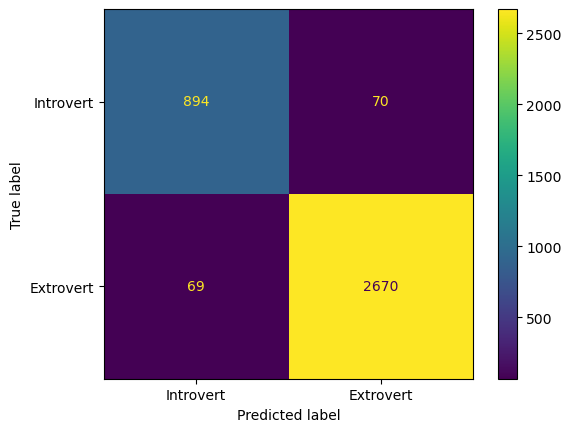

In [138]:
scores, cm = measure_method(df.copy(), strategy='mode')
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int), display_labels=["Introvert", "Extrovert"])
disp.plot()
plt.show()

### Mean Fill

accuracy: 0.9645325620913889
f1: 0.976010125342255


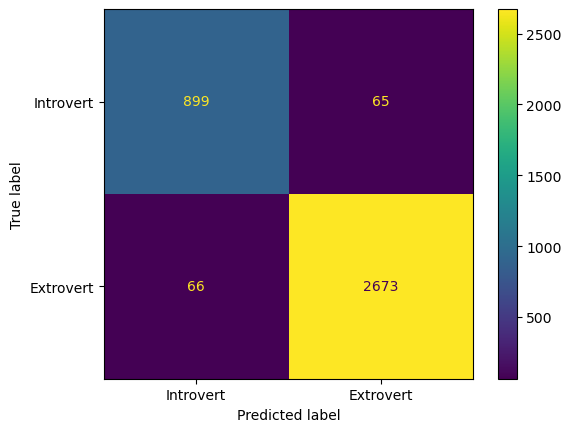

In [139]:
scores, cm = measure_method(df.copy(), strategy='mean')
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int), display_labels=["Introvert", "Extrovert"])
disp.plot()
plt.show()

### Special Fill

100%|██████████| 18524/18524 [01:06<00:00, 278.22it/s]


accuracy: 0.9618869923604491
f1: 0.9742837039386364


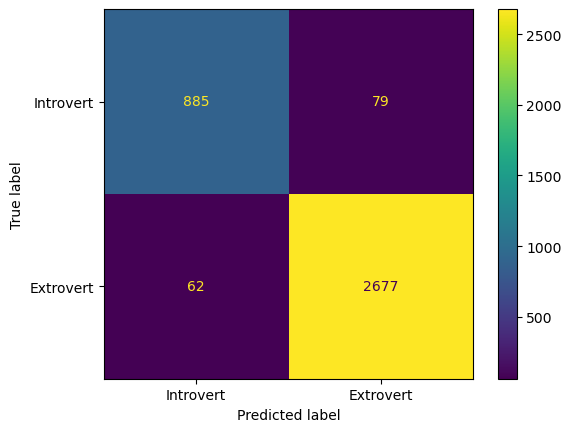

In [140]:
scores, cm = measure_method(df.copy(), strategy='special')
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int), display_labels=["Introvert", "Extrovert"])
disp.plot()
plt.show()

## Dataset sem Drained_after_socializing

In [141]:
df_cut = cut_dataframe(df, ['Drained_after_socializing'])

In [142]:
df_cut.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,label
0,0.0,No,6.0,4.0,15.0,5.0,1
1,1.0,No,7.0,3.0,10.0,8.0,1
2,6.0,Yes,1.0,0.0,3.0,0.0,0
3,3.0,No,7.0,3.0,11.0,5.0,1
4,1.0,No,4.0,4.0,13.0,NaN,1


### Mode Fill

accuracy: 0.9622113307858449
f1: 0.9744481478978516


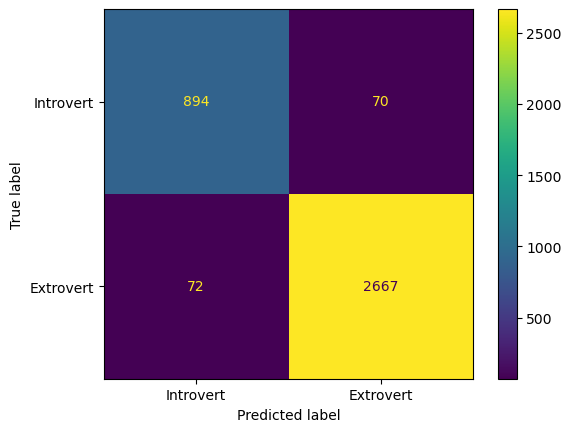

In [143]:
scores, cm = measure_method(df.copy(), strategy='mode')
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int), display_labels=["Introvert", "Extrovert"])
disp.plot()
plt.show()

### Mean Fill

accuracy: 0.9642626274108597
f1: 0.9758219808628693


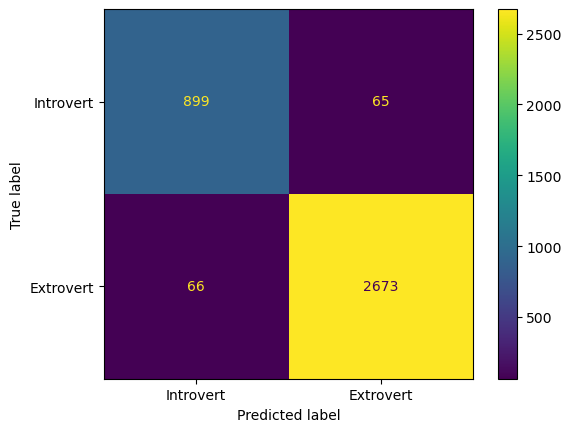

In [144]:
scores, cm = measure_method(df.copy(), strategy='mean')
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int), display_labels=["Introvert", "Extrovert"])
disp.plot()
plt.show()

### Special Fill

  0%|          | 0/18524 [00:00<?, ?it/s]

100%|██████████| 18524/18524 [01:07<00:00, 272.48it/s]


accuracy: 0.9615635429327597
f1: 0.974050155502252


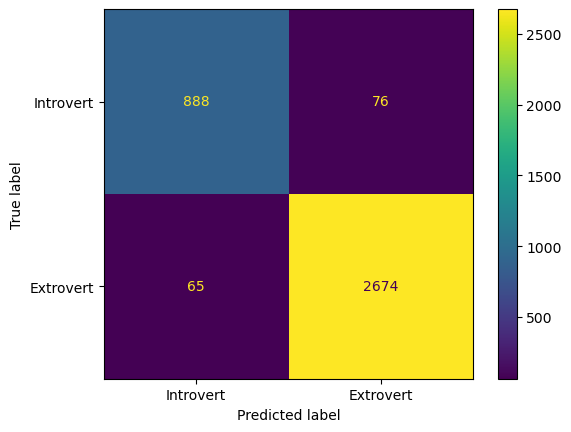

In [145]:
scores, cm = measure_method(df.copy(), strategy='special')
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int), display_labels=["Introvert", "Extrovert"])
disp.plot()
plt.show()

## Treino com SMOTE

### Mode Fill

accuracy: 0.9500648385376135
f1: 0.965940192741326


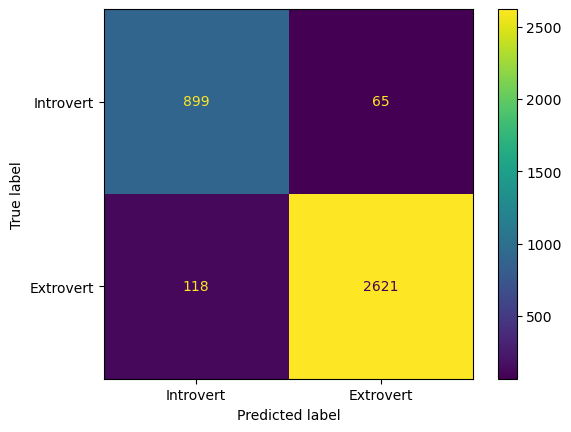

In [146]:
scores, cm = measure_method(df.copy(), strategy='mode', smote=True)
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int), display_labels=["Introvert", "Extrovert"])
disp.plot()
plt.show()

### Mean Fill

accuracy: 0.9530878242291225
f1: 0.9679849607842208


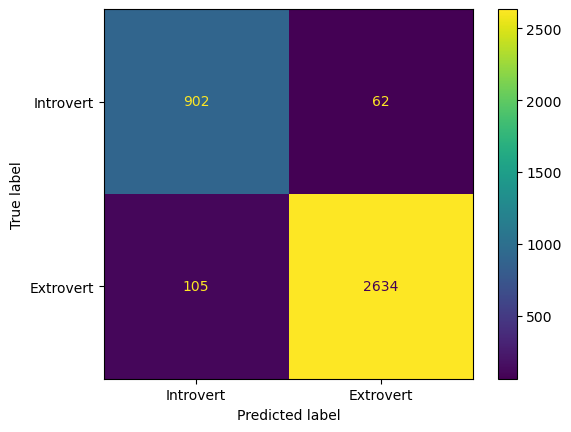

In [147]:
scores, cm = measure_method(df.copy(), strategy='mean', smote=True)
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int), display_labels=["Introvert", "Extrovert"])
disp.plot()
plt.show()

### Special Fill

100%|██████████| 18524/18524 [01:06<00:00, 276.85it/s]


accuracy: 0.9510904649895215
f1: 0.9666697403394048


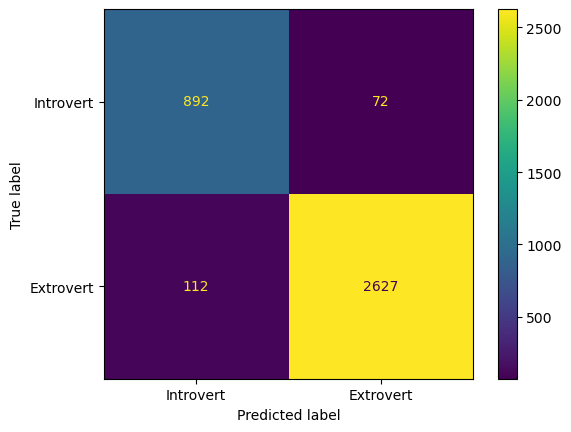

In [148]:
scores, cm = measure_method(df.copy(), strategy='special', smote=True)
print('accuracy:', np.mean(scores['test_accuracy']))
print('f1:', np.mean(scores['test_f1']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.astype(int), display_labels=["Introvert", "Extrovert"])
disp.plot()
plt.show()

## Treina o modelo e gera o CSV

In [149]:
df_train = cut_dataframe(original_df, ['id', 'Personality'])
df_train.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,label
0,0.0,No,6.0,4.0,No,15.0,5.0,1
1,1.0,No,7.0,3.0,No,10.0,8.0,1
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,0
3,3.0,No,7.0,3.0,No,11.0,5.0,1
4,1.0,No,4.0,4.0,No,13.0,NaN,1


In [150]:
df_train = preprocess(df_train, strategy="mean")
x = df_train.drop(columns=['label'])
y = df_train['label']
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [151]:
test_df = pd.read_csv('../data/C1/test.csv')
test_df = cut_dataframe(test_df, ['id'])
predictions = model.predict(preprocess(test_df, strategy="mean"))

In [ ]:
sample_submission = pd.read_csv('../data/C1/sample_submission.csv')

submission = sample_submission.copy()
submission["label"] = ["Extrovert" if value == 1 else "Introvert" for value in predictions]

submission[["id", "label"]].to_csv("../data/C1/submission.csv", index=False)